# 卒業研究15：ニューラルネットワークのハイパーパラメータの調整
ニューラルネットの学習率をベイズ最適化を用いて可能にします．
## 20S1066 坂西和也

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# データの読み込み
import os
# カレントディレクトリを取得
data_path = os.getcwd()

In [ ]:
data_path

'/content'

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv(data_path + '/drive/MyDrive/卒研/EuF3_data.csv' , sep='\t')

In [ ]:
data.head()

,Velocity (mm/s),EuF3_w0T7_8S5_85,EuF3_w1T7_8S5_85,EuF3_w2T7_8S5_85,EuF3_w3T7_8S5_85
0,-20.000000,373.275017,89.683715,59.446287,38.924525
1,-19.685039,373.239700,90.317998,59.679393,38.652381
2,-19.370079,373.287540,90.972404,59.770151,38.261999
3,-19.055118,373.344075,91.617714,59.701970,37.806983
4,-18.740157,373.326817,92.212957,59.470467,37.346615


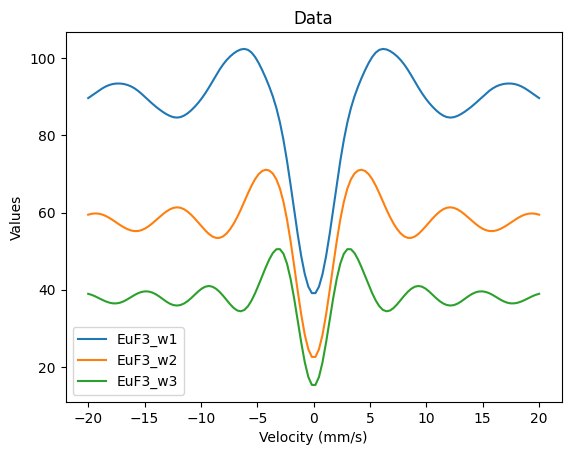

In [ ]:
# 横軸に1列目のデータを使用
x = data.iloc[:, 0]

# 3列目から5列目のデータをそれぞれプロット
for i in range(2, 5):
    plt.plot(x, data.iloc[:, i], label=f'EuF3_w{i-1}')

# 凡例を追加
plt.legend()

# グラフのタイトルと軸ラベルを設定
plt.title('Data')
plt.xlabel('Velocity (mm/s)')
plt.ylabel('Values')

# グラフを表示
plt.show()

# EuF3_w1

In [ ]:
# 新しいDataFrame w1 を作成し、元の1列目をコピー
w1 = pd.DataFrame()
w1['Velocity (mm/s)'] = data.iloc[:, 0]

# 3列目のデータに指定された係数を順に掛け、新しい列として挿入
factors = [0.1, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01, \
           0.009, 0.008, 0.007, 0.006, 0.005, 0.004, 0.003, 0.002, 0.001]

for factor in factors:
    w1[f'EuF_w1 * {factor:.3f}'] = data.iloc[:, 2] * factor

# w1 の内容を表示（オプション）
w1.head()

,Velocity (mm/s),EuF_w1 * 0.100,EuF_w1 * 0.090,EuF_w1 * 0.080,EuF_w1 * 0.070,EuF_w1 * 0.060,EuF_w1 * 0.050,EuF_w1 * 0.040,EuF_w1 * 0.030,EuF_w1 * 0.020,EuF_w1 * 0.010,EuF_w1 * 0.009,EuF_w1 * 0.008,EuF_w1 * 0.007,EuF_w1 * 0.006,EuF_w1 * 0.005,EuF_w1 * 0.004,EuF_w1 * 0.003,EuF_w1 * 0.002,EuF_w1 * 0.001
0,-20.000000,8.968372,8.071534,7.174697,6.277860,5.381023,4.484186,3.587349,2.690511,1.793674,0.896837,0.807153,0.717470,0.627786,0.538102,0.448419,0.358735,0.269051,0.179367,0.089684
1,-19.685039,9.031800,8.128620,7.225440,6.322260,5.419080,4.515900,3.612720,2.709540,1.806360,0.903180,0.812862,0.722544,0.632226,0.541908,0.451590,0.361272,0.270954,0.180636,0.090318
2,-19.370079,9.097240,8.187516,7.277792,6.368068,5.458344,4.548620,3.638896,2.729172,1.819448,0.909724,0.818752,0.727779,0.636807,0.545834,0.454862,0.363890,0.272917,0.181945,0.090972
3,-19.055118,9.161771,8.245594,7.329417,6.413240,5.497063,4.580886,3.664709,2.748531,1.832354,0.916177,0.824559,0.732942,0.641324,0.549706,0.458089,0.366471,0.274853,0.183235,0.091618
4,-18.740157,9.221296,8.299166,7.377037,6.454907,5.532777,4.610648,3.688518,2.766389,1.844259,0.922130,0.829917,0.737704,0.645491,0.553278,0.461065,0.368852,0.276639,0.184426,0.092213


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [ ]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

In [ ]:
# データ数の設定
number = 25
random_number = 25

# 0行目のデータを取得
row_at_zero_index = w1.iloc[0]

# カラムのリストを取得
columns_to_plot = w1.columns[1:].tolist()

# 教師信号を作成
y = [1]*number + [0]*random_number

Log = pd.DataFrame()
NN = pd.DataFrame()
Bay = pd.DataFrame()
# ニューラルネットワーク用のハイパーパラメータ範囲を設定
param_dist = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
    'learning_rate_init': [0.001, 0.01, 0.1],
    # 他に最適化したいパラメータを追加
}
# ニューラルネットワーク用のベイズ最適化のパラメータ範囲を設定
bayes_param_space = {
    'hidden_layer_sizes': Integer(50, 200),
    'alpha': Real(0.0001, 1, prior='log-uniform'),
    'learning_rate_init': Real(0.001, 0.1, prior='log-uniform'),
    # 他の最適化したいパラメータを追加
}


In [ ]:
%%time
# 各カラムごとに
for column in columns_to_plot:
    dataset = pd.DataFrame()
    # 元データからノイズを付加したデータを作成
    for i in range(number):
        np.random.seed(i)
        column_name = f'noisy_{i}'
        # 正規乱数のノイズは、平均0、分散は各x軸のデータのy軸値
        variance = w1[column].values
        noise = np.random.normal(0, np.sqrt(variance))
        dataset[column_name] = w1[column] + noise

    # 乱数のみのデータを作成
    for i in range(random_number):
        j = i + number
        np.random.seed(j)
        column_name = f'random_{i}'
        # 正規乱数のノイズは、平均は0行目のデータの値、分散も0行目のデータの値
        noise = np.random.normal(row_at_zero_index[column], np.sqrt(row_at_zero_index[column]),\
                                  size=w1[column].shape)
        dataset[column_name] = noise

    # 入力データとして、各カラムを1つのサンプルとする
    X = dataset
    # データセットをトレーニングセットとテストセットに分割
    X_train, X_test, y_train, y_test = train_test_split(X.T, y, test_size=0.3, random_state=111)

    # ロジスティック回帰モデルを訓練
    clf = LogisticRegression(max_iter=10000)
    clf.fit(X_train, y_train)
    # テストデータを使って予測
    y_pred = clf.predict(X_test)
    # 評価
    Log[column] = [clf.score(X_test, y_test)]

    # ニューラルネットワークのランダムサーチ
    mlp = MLPClassifier(max_iter=1000, random_state=111)
    random_search = RandomizedSearchCV(mlp, param_distributions=param_dist, n_iter=15, cv=5, random_state=111)
    random_search.fit(X_train, y_train)
    # 最適なパラメータでのモデルの評価
    best_mlp = random_search.best_estimator_
    y_pred = best_mlp.predict(X_test)
    NN[column] = [accuracy_score(y_test, y_pred)]

    # ベイズ最適化を用いたニューラルネットワークモデル
    mlp = MLPClassifier(max_iter=1000, random_state=111)
    bayes_search = BayesSearchCV(mlp, bayes_param_space, n_iter=10, cv=5, random_state=111)
    bayes_search.fit(X_train, y_train)

    # 最適なパラメータでのモデルの評価
    best_mlp = bayes_search.best_estimator_
    y_pred = best_mlp.predict(X_test)
    Bay[column] = [accuracy_score(y_test, y_pred)]

CPU times: user 4min 59s, sys: 2min 50s, total: 7min 50s
Wall time: 5min 36s


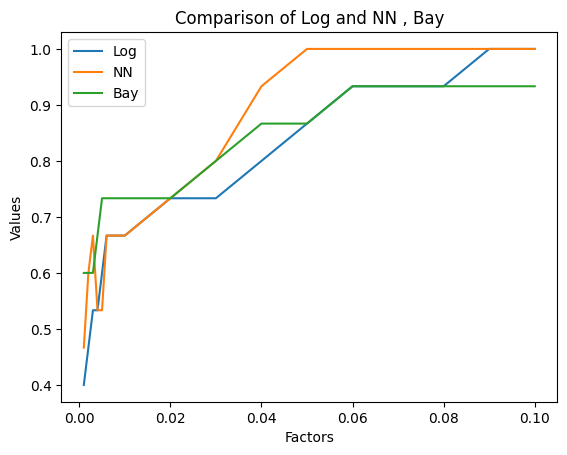

In [ ]:
# factors リストを DataFrame に変換
factors_df = pd.DataFrame({'Factors': factors})
# インデックスをリセット
factors_df.reset_index(drop=True, inplace=True)
Log_reset = Log.T.reset_index(drop=True)
NN_reset = NN.T.reset_index(drop=True)
Bay_reset = Bay.T.reset_index(drop=True)

# インデックスをリセットしたDataFrameを結合
result_df = pd.concat([factors_df, Log_reset, NN_reset , Bay_reset ], axis=1)

result_df = pd.concat([factors_df, Log_reset, NN_reset , Bay_reset], axis=1)
result_df.columns = ['Factors', 'Log', 'NN' ,'Bay']

# Factors を横軸に設定
x = result_df['Factors']

# Log と NN を重ねてプロット
plt.plot(x, result_df['Log'], label='Log')
plt.plot(x, result_df['NN'], label='NN')
plt.plot(x, result_df['Bay'], label='Bay')

# 凡例を追加
plt.legend()

# グラフのタイトルと軸ラベルを設定
plt.title('Comparison of Log and NN , Bay')
plt.xlabel('Factors')
plt.ylabel('Values')

# グラフを表示
plt.show()

# EuF_w2

In [ ]:
# 新しいDataFrame w1 を作成し、元の1列目をコピー
w2 = pd.DataFrame()
w2['Velocity (mm/s)'] = data.iloc[:, 0]

for factor in factors:
    w2[f'EuF_w2 * {factor:.3f}'] = data.iloc[:, 3] * factor

# w2 の内容を表示（オプション）
w2.head()

,Velocity (mm/s),EuF_w2 * 0.100,EuF_w2 * 0.090,EuF_w2 * 0.080,EuF_w2 * 0.070,EuF_w2 * 0.060,EuF_w2 * 0.050,EuF_w2 * 0.040,EuF_w2 * 0.030,EuF_w2 * 0.020,EuF_w2 * 0.010,EuF_w2 * 0.009,EuF_w2 * 0.008,EuF_w2 * 0.007,EuF_w2 * 0.006,EuF_w2 * 0.005,EuF_w2 * 0.004,EuF_w2 * 0.003,EuF_w2 * 0.002,EuF_w2 * 0.001
0,-20.000000,5.944629,5.350166,4.755703,4.161240,3.566777,2.972314,2.377851,1.783389,1.188926,0.594463,0.535017,0.475570,0.416124,0.356678,0.297231,0.237785,0.178339,0.118893,0.059446
1,-19.685039,5.967939,5.371145,4.774351,4.177558,3.580764,2.983970,2.387176,1.790382,1.193588,0.596794,0.537115,0.477435,0.417756,0.358076,0.298397,0.238718,0.179038,0.119359,0.059679
2,-19.370079,5.977015,5.379314,4.781612,4.183911,3.586209,2.988508,2.390806,1.793105,1.195403,0.597702,0.537931,0.478161,0.418391,0.358621,0.298851,0.239081,0.179310,0.119540,0.059770
3,-19.055118,5.970197,5.373177,4.776158,4.179138,3.582118,2.985099,2.388079,1.791059,1.194039,0.597020,0.537318,0.477616,0.417914,0.358212,0.298510,0.238808,0.179106,0.119404,0.059702
4,-18.740157,5.947047,5.352342,4.757637,4.162933,3.568228,2.973523,2.378819,1.784114,1.189409,0.594705,0.535234,0.475764,0.416293,0.356823,0.297352,0.237882,0.178411,0.118941,0.059470


In [ ]:
# 0行目のデータを取得
row_at_zero_index = w2.iloc[0]

# カラムのリストを取得
columns_to_plot = w2.columns[1:].tolist()

Log = pd.DataFrame()
NN = pd.DataFrame()

In [ ]:
%%time
# 各カラムごとに
for column in columns_to_plot:
    dataset = pd.DataFrame()
    # 元データからノイズを付加したデータを作成
    for i in range(number):
        np.random.seed(i)
        column_name = f'noisy_{i}'
        # 正規乱数のノイズは、平均0、分散は各x軸のデータのy軸値
        variance = w2[column].values
        noise = np.random.normal(0, np.sqrt(variance))
        dataset[column_name] = w2[column] + noise

    # 乱数のみのデータを作成
    for i in range(random_number):
        j = i + number
        np.random.seed(j)
        column_name = f'random_{i}'
        # 正規乱数のノイズは、平均は0行目のデータの値、分散も0行目のデータの値
        noise = np.random.normal(row_at_zero_index[column], np.sqrt(row_at_zero_index[column]),\
                                  size=w2[column].shape)
        dataset[column_name] = noise

    # 入力データとして、各カラムを1つのサンプルとする
    X = dataset
    # データセットをトレーニングセットとテストセットに分割
    X_train, X_test, y_train, y_test = train_test_split(X.T, y, test_size=0.3, random_state=111)

    # ロジスティック回帰モデルを訓練
    clf = LogisticRegression(max_iter=10000)
    clf.fit(X_train, y_train)
    # テストデータを使って予測
    y_pred = clf.predict(X_test)
    # 評価
    Log[column] = [clf.score(X_test, y_test)]

    # ニューラルネットワークのランダムサーチ
    mlp = MLPClassifier(max_iter=1000, random_state=111)
    random_search = RandomizedSearchCV(mlp, param_distributions=param_dist, n_iter=10, cv=5, random_state=111)
    random_search.fit(X_train, y_train)

    # 最適なパラメータでのモデルの評価
    best_mlp = random_search.best_estimator_
    y_pred = best_mlp.predict(X_test)
    NN[column] = [accuracy_score(y_test, y_pred)]

CPU times: user 1min 38s, sys: 1min 2s, total: 2min 40s
Wall time: 2min 25s


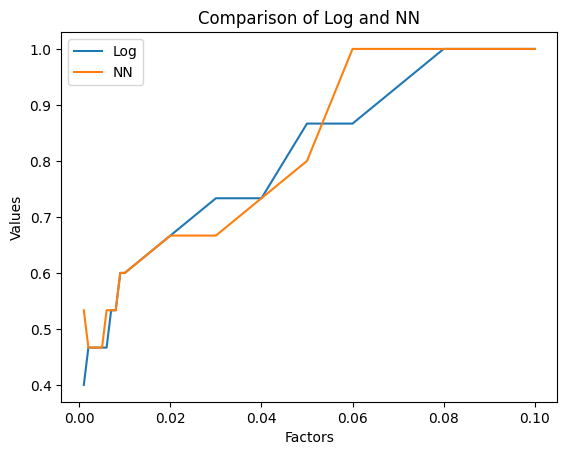

In [ ]:
# factors リストを DataFrame に変換
factors_df = pd.DataFrame({'Factors': factors})
# インデックスをリセット
factors_df.reset_index(drop=True, inplace=True)
Log_reset = Log.T.reset_index(drop=True)
NN_reset = NN.T.reset_index(drop=True)

# インデックスをリセットしたDataFrameを結合
result_df = pd.concat([factors_df, Log_reset, NN_reset ], axis=1)

result_df = pd.concat([factors_df, Log_reset, NN_reset ], axis=1)
result_df.columns = ['Factors', 'Log', 'NN' ]

# Factors を横軸に設定
x = result_df['Factors']

# Log と NN を重ねてプロット
plt.plot(x, result_df['Log'], label='Log')
plt.plot(x, result_df['NN'], label='NN')

# 凡例を追加
plt.legend()

# グラフのタイトルと軸ラベルを設定
plt.title('Comparison of Log and NN')
plt.xlabel('Factors')
plt.ylabel('Values')

# グラフを表示
plt.show()

# EuF_w3

In [ ]:
# 新しいDataFrame w1 を作成し、元の1列目をコピー
w3 = pd.DataFrame()
w3['Velocity (mm/s)'] = data.iloc[:, 0]

for factor in factors:
    w3[f'EuF_w3 * {factor:.3f}'] = data.iloc[:, 4] * factor

# w3 の内容を表示（オプション）
w3.head()

,Velocity (mm/s),EuF_w3 * 0.100,EuF_w3 * 0.090,EuF_w3 * 0.080,EuF_w3 * 0.070,EuF_w3 * 0.060,EuF_w3 * 0.050,EuF_w3 * 0.040,EuF_w3 * 0.030,EuF_w3 * 0.020,EuF_w3 * 0.010,EuF_w3 * 0.009,EuF_w3 * 0.008,EuF_w3 * 0.007,EuF_w3 * 0.006,EuF_w3 * 0.005,EuF_w3 * 0.004,EuF_w3 * 0.003,EuF_w3 * 0.002,EuF_w3 * 0.001
0,-20.000000,3.892452,3.503207,3.113962,2.724717,2.335471,1.946226,1.556981,1.167736,0.778490,0.389245,0.350321,0.311396,0.272472,0.233547,0.194623,0.155698,0.116774,0.077849,0.038925
1,-19.685039,3.865238,3.478714,3.092191,2.705667,2.319143,1.932619,1.546095,1.159571,0.773048,0.386524,0.347871,0.309219,0.270567,0.231914,0.193262,0.154610,0.115957,0.077305,0.038652
2,-19.370079,3.826200,3.443580,3.060960,2.678340,2.295720,1.913100,1.530480,1.147860,0.765240,0.382620,0.344358,0.306096,0.267834,0.229572,0.191310,0.153048,0.114786,0.076524,0.038262
3,-19.055118,3.780698,3.402628,3.024559,2.646489,2.268419,1.890349,1.512279,1.134209,0.756140,0.378070,0.340263,0.302456,0.264649,0.226842,0.189035,0.151228,0.113421,0.075614,0.037807
4,-18.740157,3.734662,3.361195,2.987729,2.614263,2.240797,1.867331,1.493865,1.120398,0.746932,0.373466,0.336120,0.298773,0.261426,0.224080,0.186733,0.149386,0.112040,0.074693,0.037347


In [ ]:
# データ数の設定
number = 25
random_number = 25

# 0行目のデータを取得
row_at_zero_index = w3.iloc[0]

# カラムのリストを取得
columns_to_plot = w3.columns[1:].tolist()

Log = pd.DataFrame()
NN = pd.DataFrame()

In [ ]:
%%time

# 各カラムごとに
for column in columns_to_plot:
    dataset = pd.DataFrame()
    # 元データからノイズを付加したデータを作成
    for i in range(number):
        np.random.seed(i)
        column_name = f'noisy_{i}'
        # 正規乱数のノイズは、平均0、分散は各x軸のデータのy軸値
        variance = w3[column].values
        noise = np.random.normal(0, np.sqrt(variance))
        dataset[column_name] = w3[column] + noise

    # 乱数のみのデータを作成
    for i in range(random_number):
        j = i + number
        np.random.seed(j)
        column_name = f'random_{i}'
        # 正規乱数のノイズは、平均は0行目のデータの値、分散も0行目のデータの値
        noise = np.random.normal(row_at_zero_index[column], np.sqrt(row_at_zero_index[column]),\
                                  size=w3[column].shape)
        dataset[column_name] = noise

    # 入力データとして、各カラムを1つのサンプルとする
    X = dataset
    # データセットをトレーニングセットとテストセットに分割
    X_train, X_test, y_train, y_test = train_test_split(X.T, y, test_size=0.3, random_state=111)

    # ロジスティック回帰モデルを訓練
    clf = LogisticRegression(max_iter=10000)
    clf.fit(X_train, y_train)
    # テストデータを使って予測
    y_pred = clf.predict(X_test)
    # 評価
    Log[column] = [clf.score(X_test, y_test)]

    # ニューラルネットワークのランダムサーチ
    mlp = MLPClassifier(max_iter=1000, random_state=111)
    random_search = RandomizedSearchCV(mlp, param_distributions=param_dist, n_iter=10, cv=5, random_state=111)
    random_search.fit(X_train, y_train)

    # 最適なパラメータでのモデルの評価
    best_mlp = random_search.best_estimator_
    y_pred = best_mlp.predict(X_test)
    NN[column] = [accuracy_score(y_test, y_pred)]

CPU times: user 1min 28s, sys: 49.9 s, total: 2min 17s
Wall time: 1min 38s


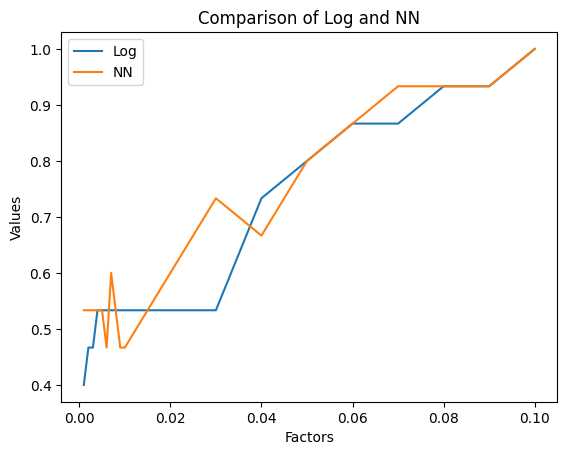

In [ ]:
# factors リストを DataFrame に変換
factors_df = pd.DataFrame({'Factors': factors})
# インデックスをリセット
factors_df.reset_index(drop=True, inplace=True)
Log_reset = Log.T.reset_index(drop=True)
NN_reset = NN.T.reset_index(drop=True)

# インデックスをリセットしたDataFrameを結合
result_df = pd.concat([factors_df, Log_reset, NN_reset ], axis=1)

result_df = pd.concat([factors_df, Log_reset, NN_reset ], axis=1)
result_df.columns = ['Factors', 'Log', 'NN']

# Factors を横軸に設定
x = result_df['Factors']

# Log と NN を重ねてプロット
plt.plot(x, result_df['Log'], label='Log')
plt.plot(x, result_df['NN'], label='NN')

# 凡例を追加
plt.legend()

# グラフのタイトルと軸ラベルを設定
plt.title('Comparison of Log and NN')
plt.xlabel('Factors')
plt.ylabel('Values')

# グラフを表示
plt.show()